In [1]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 13020), started 4 days, 9:46:21 ago. (Use '!kill 13020' to kill it.)

#### Loading the relevant datasets (15/100)

Train Data shape: 
(15026, 4)

Val Data shape: 
(3757, 4)

Test Data shape: 
(4696, 4)

_____________________________________________

Train Data coloumns: 
['age' 'ethnicity' 'gender' 'img_name']

Val Data coloumns: 
['age' 'ethnicity' 'gender' 'img_name']

Test Data coloumns: 
['age' 'ethnicity' 'gender' 'img_name']

_____________________________________________

Train Data Gender Distribution:
0    7864
1    7162
Name: gender, dtype: int64

Val Data Gender Distribution:
0    1965
1    1792
Name: gender, dtype: int64

Test Data Gender Distribution:
0    2456
1    2240
Name: gender, dtype: int64

_____________________________________________

Train Data Ethnicity Distribution:
0    6372
1    2869
3    2524
2    2186
4    1075
Name: ethnicity, dtype: int64

Val Data Ethnicity Distribution:
0    1593
1     717
3     632
2     547
4     268
Name: ethnicity, dtype: int64

Test Data Ethnicity Distribution:
0    1991
1     896
3     790
2     683
4     336
Name: ethnicity, dtype: int64

___

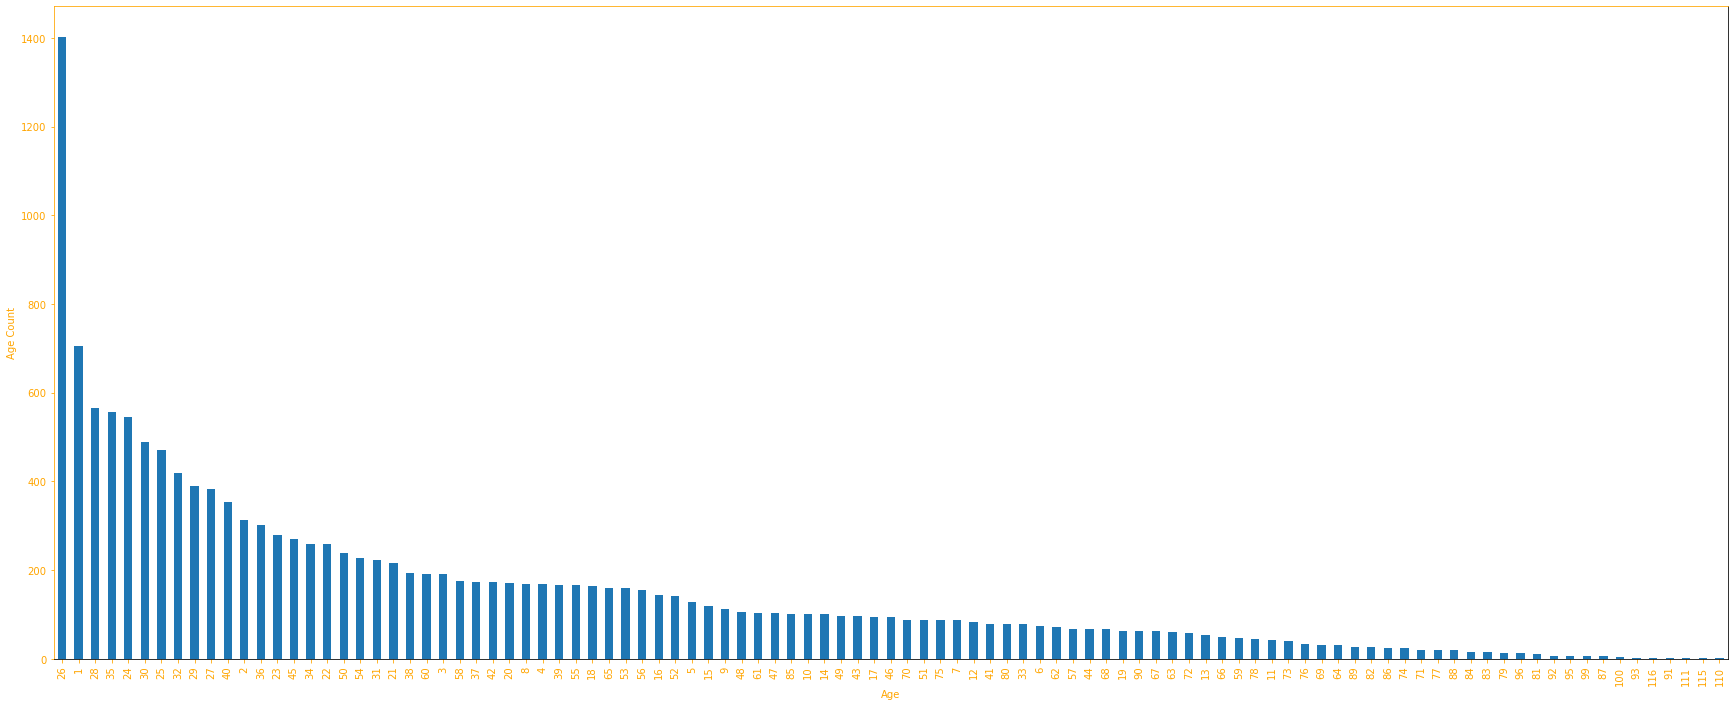

In [2]:
# load the datasets using the csv files train, val and test 
# (3)
dfTrain = pd.read_csv('./data/train.csv')
dfVal = pd.read_csv('./data/val.csv')
dfTest = pd.read_csv('./data/test.csv')

# print the shapes of the dataframes 
# (3)
print(f"Train Data shape: \n{dfTrain.shape}\n")
print(f"Val Data shape: \n{dfVal.shape}\n")
print(f"Test Data shape: \n{dfTest.shape}\n")
print("_____________________________________________\n")

# print the column names from either one of the dataframes 
# (1)
print(f"Train Data coloumns: \n{dfTrain.columns.values}\n")
print(f"Val Data coloumns: \n{dfVal.columns.values}\n")
print(f"Test Data coloumns: \n{dfTest.columns.values}\n")
print("_____________________________________________\n")

# print the proportional distribution of gender in all three datasets(i.e., number of male and female) 
# (3)
print(f"Train Data Gender Distribution:\n{dfTrain['gender'].value_counts()}\n")
print(f"Val Data Gender Distribution:\n{dfVal['gender'].value_counts()}\n")
print(f"Test Data Gender Distribution:\n{dfTest['gender'].value_counts()}\n")
print("_____________________________________________\n")

# print the proportional distribution of ethnicity in all three datasets 
# (3)
print(f"Train Data Ethnicity Distribution:\n{dfTrain['ethnicity'].value_counts()}\n")
print(f"Val Data Ethnicity Distribution:\n{dfVal['ethnicity'].value_counts()}\n")
print(f"Test Data Ethnicity Distribution:\n{dfTest['ethnicity'].value_counts()}\n")
print("_____________________________________________\n")

# plot the age distribution from the training dataset where the x-axis plots the age and the y-axis depicts the count of individuals within each age group. For example, individuals with age=1 are: 
# (2)

graph = dfTrain['age'].value_counts().plot(kind='bar', figsize = (30,12), xlabel = "Age", ylabel = "Age Count")
graph.xaxis.label.set_color('orange')        #setting up X-axis label color to white
graph.yaxis.label.set_color('orange')          #setting up Y-axis label color to white
graph.tick_params(axis='x', colors='orange')    #setting up X-axis tick color to white
graph.tick_params(axis='y', colors='orange')  #setting up Y-axis tick color to white
graph.spines['left'].set_color('orange')        # setting up Y-axis tick color to white
graph.spines['top'].set_color('orange')         #setting up above X-axis tick color to white

#### Create the ImageDataGenerators (22/100)

Found 15026 validated image filenames.
Found 4696 validated image filenames.
Found 3757 validated image filenames.


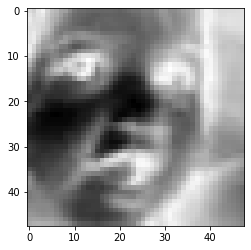

In [3]:
# ImageDataGenerator is an iterator.

# specify the batch size hyperparameter. You can experiment with different batch sizes
batch_size = 16

# create the ImageDataGenerator with rescaling that will generate batched tensors representing images with real-time data augmentation
# use at least two of the augmentation strategies. For example, fill_mode='nearest'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (3)
train_img_gen = ImageDataGenerator(
    brightness_range=(0.5,1),
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1./255
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance to link the image folder and the dataframe.
# also include the, batch size, image size and the seed.
# make sure to include the following arguments
# color_mode='grayscale', class_mode='multi_output'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (5)
# TODO

train_img_flow = train_img_gen.flow_from_dataframe(
    dfTrain,
    directory=r"./data/images/train/",
    x_col= "img_name",
    y_col= ["age", "ethnicity", "gender"],
    batch_size=16,
    color_mode='grayscale',
    class_mode='multi_output',
    target_size=(48, 48),
    seed=SEED,
    shuffle=True
)

# similarly, create an ImageDataGenerator for the validation dataset and make sure not to use any of the augmentation strategies except rescaling the image
# (2)
val_img_gen = ImageDataGenerator(
    rescale=1./255
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance with the same arguments as above
# make sure to specify the following arguments:
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)

test_img_flow = val_img_gen.flow_from_dataframe(
    dfTest,
    directory=r"./data/images/test/",
    x_col= "img_name",
    y_col= ["age", "ethnicity", "gender"],
    batch_size=16,
    color_mode='grayscale',
    class_mode='multi_output',
    shuffle=False,
    target_size=(48, 48),
    seed=SEED
)

# use the method "flow_from_dataframe" from the val_img_gen instance to link the test dataframe and the test data folder
# In addition, make sure to specify the following arguments
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
val_img_flow = val_img_gen.flow_from_dataframe(
    dfVal,
    directory=r"./data/images/val/",
    x_col= "img_name",
    y_col= ["age", "ethnicity", "gender"],
    batch_size=16,
    color_mode='grayscale',
    class_mode='multi_output',
    shuffle=False,
    target_size=(48, 48),
    seed=SEED
)

# enumerate through the validation data generator created above and plot first grayscale image 
# (2)
for i, element in enumerate(val_img_flow):
    plt.imshow(element[0][0],cmap=plt.cm.binary)
    plt.show()    
    break


#### Create the model (44/100)

In [4]:
# specify the model input with the required shape 
# (1)
model_input = keras.Input(shape=(48, 48, 1)) 

# The shared layers
# Include at least one Conv2D layer, MaxPooling2D layer and a Flatten layer
# you can have as many layers as possible, but make sure not to overfit your model using the training data
# (10)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(model_input) 
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x) 
x = layers.Flatten()(x)

# Task specific layers
# Include at least one Dense layer as a task specific layer before generating the output for age

# (2)

dense_layer_1 = layers.Dense(128, activation="relu", name="Dense_Layer_1")(x) 

#model = keras.Model(inputs=model_input, outputs=dense_layer)

# Include the age output and make sure to include the following arguments
# activation='linear', name='xxx'(any name)
# make sure to name your output layers so that different metrics to be used can be linked accordingly
# please note that the age prediction is a regression task

# (2)
age_output = layers.Dense(1, activation="linear", name="Dense_Age")(dense_layer_1)
#age_output = layers.Flatten()(age_output)

# Similar to above, specify one or more Dense layers as task specific layers for ethnicity prediction
# (2)
dense_layer_2 = layers.Dense(128, activation="relu", name="Dense_Layer_2")(x) 

# Include the ethnicity output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a multi-class classification task
# (2)

eth_output = layers.Dense(5, activation="softmax", name="Dense_Ethnicity")(dense_layer_2)
#eth_output = layers.Flatten()(eth_output)

# Similar to above, specify one or more Dense layers as task specific layers for gender prediction
# TODO
# (2)

dense_layer_3 = layers.Dense(128, activation="relu")(x) 

# Include the gender output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a binary classification task

# (2)

gen_output = layers.Dense(2, activation="relu", name="Dense_Gender")(dense_layer_3)
#gen_output = layers.Flatten()(gen_output)

# create the model with the required input and the outputs.
# pelase make sure that the outputs can be included in a list and make sure to keep note of the order
# (3)

model = keras.Model(inputs=model_input, outputs=[age_output, eth_output, gen_output])


# print the model summary
# (0.5)

print(model.summary())

# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# TODO
# (2)

optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)

# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)
losses = ['MeanAbsoluteError', 'sparse_categorical_crossentropy', 'binary_crossentropy']

# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
# loss_weights=[0.001, 0.5, 0.5]
# please remember to use the relevant metric for each task by assigning it to the correct output
# (2)

model.compile(optimizer=optimizer, loss=losses, metrics=['MeanAbsoluteError', 'Accuracy' , 'BinaryAccuracy'], loss_weights=[0.001, 0.5, 0.5])

# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# (2)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ModelCheckpoint
# monitor validation loss and save the best model weights
# (2)

checkpoints = keras.callbacks.ModelCheckpoint(
    filepath='./models/checkpoints',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Initiallize TensorBoard
# (2)

tensorboard = keras.callbacks.TensorBoard(
    log_dir='./logs/tensorlog'
)

# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# TODO
# (2)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)

model.fit(
    x=train_img_flow,
    validation_data=val_img_flow,
    epochs=10, 
    batch_size=64, 
    callbacks=[reduce_lr, early_stop, checkpoints, tensorboard],
    steps_per_epoch=len(dfTrain)/batch_size,
    validation_steps=len(dfVal)/batch_size
)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 23, 23, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 21, 21, 64)   18496       max_pooling2d[0][0]              
_______________________________________________________________________________________

ValueError: in user code:

    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\keras\engine\training.py:759 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:409 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\keras\utils\metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\keras\metrics.py:176 update_state_fn
        return ag_update_state(*args, **kwargs)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\keras\metrics.py:612 update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\keras\metrics.py:3208 accuracy  **
        y_pred.shape.assert_is_compatible_with(y_true.shape)
    C:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 5) and (None, 1) are incompatible


#### Making predictions on test data (14/100)

In [ ]:
# evaluate the trained model using the test generator
# print only the test accuracy for ethnicity and gender predictions
(4)
test_evals = model.evaluate(
    x=test_img_flow
)
print("\nDense_Ethnicity_Accuracy:")
print(test_evals[8])
print("\n\nDense_Gender_Binary_Accuracy:")
print(test_evals[12])





294/294 [==============================] - 3s 10ms/step - loss: 0.5590 - Dense_Age_loss: 9.1884 - Dense_Ethnicity_loss: 0.6609 - Dense_Gender_loss: 0.4388 - Dense_Age_mean_absolute_error: 9.1884 - Dense_Age_Accuracy: 0.0322 - Dense_Age_binary_accuracy: 0.0322 - Dense_Ethnicity_mean_absolute_error: 1.2422 - Dense_Ethnicity_Accuracy: 0.7745 - Dense_Ethnicity_binary_accuracy: 0.3793 - Dense_Gender_mean_absolute_error: 0.3331 - Dense_Gender_Accuracy: 0.6420 - Dense_Gender_binary_accuracy: 0.8821

Dense_Ethnicity_Accuracy:
0.7744889259338379


Dense_Gender_Binary_Accuracy:
0.8821337223052979


In [ ]:



# generate predictions using the test generator
(2)
predictions = model.predict(
    x=test_img_flow,
    batch_size=64, 
    callbacks=[reduce_lr, early_stop, checkpoints, tensorboard],
    verbose=1
    )


# extract the ethnicity predictions
(2)

eth_pred_lbls = np.argmax(predictions[1], axis=1)


# print the classification report for predicting ethnicity
(2)

eth_cr = classification_report(dfTest['ethnicity'].values.ravel(), eth_pred_lbls)
print(eth_cr)

# extract the gender predictions where probabilities above 0.5 are considered class 1 and if not, class 0
(2)

gen_pred_lbls = np.argmax(predictions[2], axis=1)
print(np.unique(gen_pred_lbls))

# print the classification report for predicting gender
(2)
gen_cr = classification_report(dfTest['gender'].values.ravel(), gen_pred_lbls)
print(gen_cr)

294/294 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1991
           1       0.82      0.80      0.81       896
           2       0.82      0.80      0.81       683
           3       0.68      0.74      0.71       790
           4       0.43      0.12      0.19       336

    accuracy                           0.77      4696
   macro avg       0.71      0.67      0.67      4696
weighted avg       0.76      0.77      0.76      4696

[0 1]
              precision    recall  f1-score   support

           0       0.63      0.78      0.69      2456
           1       0.67      0.49      0.57      2240

    accuracy                           0.64      4696
   macro avg       0.65      0.64      0.63      4696
weighted avg       0.65      0.64      0.63      4696



#### Present prediction results on test data(5/100)

Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields
- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
Please use a table format similar to the one mentioned below when presenting the results.

| Hyperparameters | Age(MAE) | Ethnicity(Accuracy)| Gender(Accuracy) |
|-----------------|----------|--------------------|------------------|
|Batch Size =32   | 33.192         |  0.789                  |   0.845               |
|Epoch size = 13  |   33.192       |         0.783           |  0.657                |
|Learning Rate  =0.0001|   33.192  |          0.760          |        0.720          |
|Optimizer = Adam      |   33.192       |    0.716                |    0.569              |
|Layers   Add Conv2D and a DepthWise2D              |     33.192     |      0.760              |      0.704            |
